In [0]:
!pip install torch==0.4.1
!pip install torchvision==0.2.1

    100% |████████████████████████████████| 61kB 3.8MB/s 
    100% |████████████████████████████████| 2.0MB 9.9MB/s 
    100% |████████████████████████████████| 519.5MB 36kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5924c000 @  0x7f3c15f581c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 5.8MB 5.6MB/s 
  Found existing installation: Pillow 5.2.0
    Uninstalling Pillow-5.2.0:
      Successfully uninstalled Pillow-5.2.0


In [0]:
import torch
torch.__version__

'0.4.1'

# CIFAR-10を畳み込みニューラルネットで画像分類

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [6]:
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transforms.ToTensor(),
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=False, 
                                             transform=transforms.ToTensor(),
                                             download=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
image, label = train_dataset[0]
print (image.size())
print (label)

torch.Size([3, 32, 32])
6


In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                          num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=False,
                                         num_workers=2)

In [0]:
num_classes = 10

class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [14]:
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=256, out_features=10, bias=True)
)

In [11]:
num_epochs = 20

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      #view()での変換をしない
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        #view()での変換をしない
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/20], Loss: 0.0345, val_loss: 0.0319, val_acc: 0.2085
Epoch [2/20], Loss: 0.0277, val_loss: 0.0246, val_acc: 0.4071
Epoch [3/20], Loss: 0.0238, val_loss: 0.0222, val_acc: 0.4870
Epoch [4/20], Loss: 0.0213, val_loss: 0.0202, val_acc: 0.5363
Epoch [5/20], Loss: 0.0195, val_loss: 0.0197, val_acc: 0.5512
Epoch [6/20], Loss: 0.0180, val_loss: 0.0182, val_acc: 0.5829
Epoch [7/20], Loss: 0.0167, val_loss: 0.0177, val_acc: 0.6054
Epoch [8/20], Loss: 0.0154, val_loss: 0.0182, val_acc: 0.5867
Epoch [9/20], Loss: 0.0143, val_loss: 0.0176, val_acc: 0.6163
Epoch [10/20], Loss: 0.0132, val_loss: 0.0170, val_acc: 0.6222
Epoch [11/20], Loss: 0.0121, val_loss: 0.0174, val_acc: 0.6221
Epoch [12/20], Loss: 0.0111, val_loss: 0.0179, val_acc: 0.6204
Epoch [13/20], Loss: 0.0102, val_loss: 0.0170, val_acc: 0.6484
Epoch [14/20], Loss: 0.0094, val_loss: 0.0183, val_acc: 0.6334
Epoch [15/20], Loss: 0.0083, val_loss: 0.0192, val_acc: 0.6212
Epoch [16/20], Loss: 0.0076, val_loss: 0.0190, val_acc: 0.6391
E

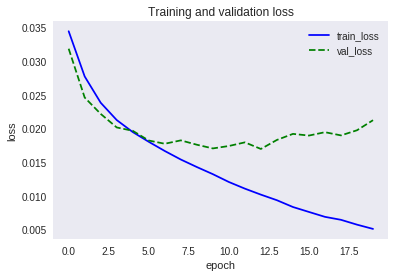

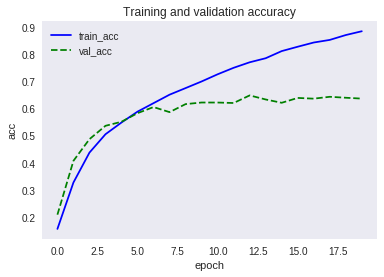

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()